In [1]:
from pytket.circuit import Circuit, Qubit, OpType, CircBox
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.extensions.qiskit import AerBackend
from pytket.utils import probs_from_counts
import matplotlib.pyplot as plt

In [2]:
clause_list = [[0, 1], 
               [0, 2],
               [1, 3], 
               [2, 3]]

In [3]:
# Implementation of XOR gate

XOR_circ = Circuit(3, name="XOR")
XOR_circ.CX(0, 2)
XOR_circ.CX(1, 2)
XOR_gate = CircBox(XOR_circ)

draw(XOR_circ)

In [4]:
# Oracle Implementation

grover_oracle_circ = Circuit(name = "Oracle")

# Coding qubits
v = grover_oracle_circ.add_q_register("V", 4)

# Auxiliar qubits
c = grover_oracle_circ.add_q_register("c", 4)

# Grover bit
grover_bit = Qubit("grover bit", 0)
grover_oracle_circ.add_qubit(grover_bit)

# Operations between pairs
for i, clause in enumerate(clause_list):
    grover_oracle_circ.add_gate(XOR_gate, [v[clause[0]], v[clause[1]], c[i]])

grover_oracle_circ.add_gate(OpType.CnX, c.to_list() + [grover_bit])

# Reset clause-cheking qubits to 1
for i, clause in enumerate(clause_list):
    grover_oracle_circ.add_gate(XOR_gate, [v[clause[0]], v[clause[1]], c[i]])

grover_oracle = CircBox(grover_oracle_circ)

draw(grover_oracle_circ)


In [5]:
# Diffuser Implementation

diffuser_circ = Circuit(name = "Diffuser")

# Coding qubits
v = diffuser_circ.add_q_register("V", 4)

# Grover bit
grover_bit = Qubit("grover bit", 0)
diffuser_circ.add_qubit(grover_bit)

# Apply Hadamard transform
for qubit in v.to_list():
    diffuser_circ.H(qubit)
    diffuser_circ.X(qubit)

diffuser_circ.add_gate(OpType.CnX, v.to_list() + [grover_bit])

for qubit in v.to_list():
    diffuser_circ.X(qubit)
    diffuser_circ.H(qubit)

diffuser = CircBox(diffuser_circ)

draw(diffuser_circ)



In [6]:
# Circuit initialization

circ = Circuit()

# Coding qubits
v = circ.add_q_register("V", 4)

# Auxiliar qubits
c = circ.add_q_register("c", 4)

# Grover bit
grover_bit = Qubit("grover bit", 0)
circ.add_qubit(grover_bit)

# Classical register
k = circ.add_c_register("cbits", 4)

# Equal superposition state
for qubit in v.to_list():
    circ.H(qubit)

# Grover's bit |-> initialization
circ.X(grover_bit)
circ.H(grover_bit)

circ.add_barrier(circ.qubits)

# Grover's first iteration
circ.add_gate(grover_oracle, circ.qubits)
circ.add_gate(diffuser, v.to_list() + [grover_bit])

circ.add_barrier(circ.qubits)

# Grover's second iteration
circ.add_gate(grover_oracle, circ.qubits)
circ.add_gate(diffuser, v.to_list() + [grover_bit])


for i in range(4):
    circ.Measure(v[i], k[i])

draw(circ)

In [7]:
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(circ)

handle = backend.process_circuit(compiled_circ, n_shots=1024)
counts = backend.get_result(handle).get_counts()

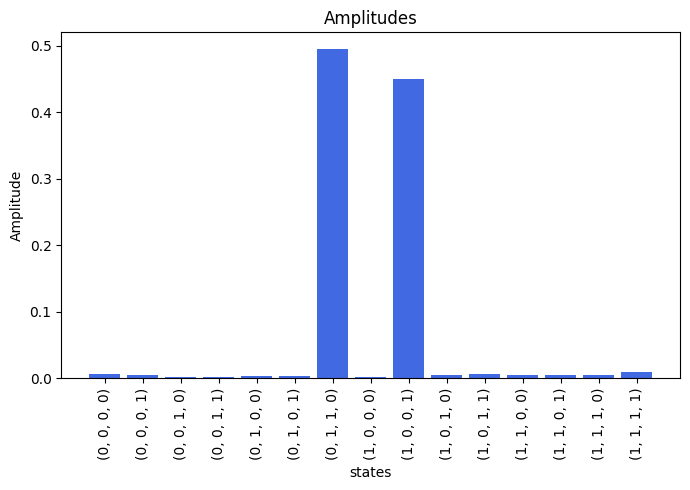

In [8]:
data = probs_from_counts(counts)

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Convert keys to string representation for plotting
keys_str = [str(key) for key in keys]

# Create the bar plot
plt.figure(figsize=(7, 5))
plt.bar(keys_str, values, color='royalblue')

# Add title and labels
plt.title('Amplitudes')
plt.xlabel('states')
plt.ylabel('Amplitude')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()